# NLP with cleaned data and CNN

In [1]:
from NLPmoviereviews.data import load_data_sent
from NLPmoviereviews.utilities import preprocessing

X_train, y_train, X_test, y_test = load_data_sent(percentage_of_sentences=100)

2022-08-09 16:14:31.170689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 16:14:31.201431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


In [2]:
X_train = [preprocessing(_) for _ in X_train]
X_train = [_.split() for _ in X_train]

In [3]:
X_test = [preprocessing(_) for _ in X_test]
X_test = [_.split() for _ in X_test]

## Tokenize the text

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
vocab_size=len(tokenizer.word_index)

In [12]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad=pad_sequences(X_train_token, dtype=float, padding='post', maxlen=200)
X_test_pad=pad_sequences(X_test_token, dtype=float, padding='post', maxlen=200)

X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [16]:
X_train_pad

array([[3.6100e+02, 3.2300e+02, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.6000e+01, 2.3000e+02, 2.0350e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0640e+03, 1.8870e+03, 1.8723e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0117e+04, 2.5690e+03, 3.7690e+03, ..., 2.8000e+01, 1.6850e+03,
        4.0000e+00],
       [1.3600e+02, 1.0600e+03, 1.6600e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.1000e+01, 1.3105e+04, 3.1600e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [6]:
from tensorflow.keras import models,layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
reg_l1 = regularizers.L1(0.001)
reg_l1l2= regularizers.L1L2(l1=0.0005, l2=0.0005)
embedding_size=100

model=models.Sequential()
#model.add(layers.Masking(mask_value=0, input_shape=(pad_length,100)))
model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, mask_zero=True, input_length=200))
model.add(layers.Conv1D(64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Conv1D(32, kernel_size=2, activation='relu', kernel_regularizer=reg_l1))
# model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu", activity_regularizer=reg_l1l2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
optim=Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history=model.fit(X_train_pad, y_train, 
          epochs=200, 
          batch_size=32,
          validation_split=0.3,
          verbose=0,
          callbacks=[es]
         )


res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
The accuracy evaluated on the test set is of 86.572%


In [11]:
from NLPmoviereviews.model import save_model

save_model(model)

2022-08-09 16:20:02.528566: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/nlp_1_model/assets


INFO:tensorflow:Assets written to: saved_model/nlp_1_model/assets


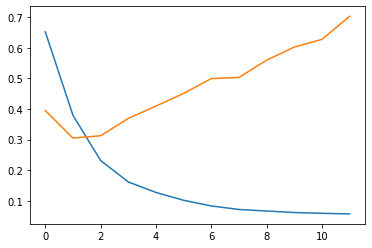

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [9]:
model.predict(X_test_pad)

array([[0.937774  ],
       [0.923465  ],
       [0.67523694],
       ...,
       [0.02242205],
       [0.95500934],
       [0.9334742 ]], dtype=float32)

In [10]:
y_test

array([1, 1, 0, ..., 0, 1, 1])